In [1]:
%cd ..

/home/bhkuser/bhklab/katy/readii_2_roqc


In [83]:
import pandas as pd
from readii_2_roqc.utils.loaders import load_dataset_config
from readii.io.writers.correlation_writer import CorrelationWriter
from readii.io.loaders import loadFileToDataFrame
from readii.process.subset import getOnlyPyradiomicsFeatures
from damply import dirs
from readii.analyze.plot_correlation import plotCorrelationHeatmap, saveCorrelationHeatmap
import re

In [3]:
dirs

DamplyDirs<Structure: NESTED>
Project Root: /home/bhkuser/bhklab/katy/readii_2_roqc
CONFIG       : ├── config
LOGS         : ├── logs
METADATA     : ├── metadata
NOTEBOOKS    : ├── workflow/notebooks
PROCDATA     : ├── data/procdata
RAWDATA      : ├── data/rawdata
RESULTS      : ├── data/results
SCRIPTS      : └── workflow/scripts

In [160]:
def make_corr_figure(dataset:str,
                     correlations:pd.DataFrame,
                     correlation_method:str = "pearson", 
                     cmap:str = 'coolwarm',
                     subset_keyword: str = None,
                     include_volume: bool = False,
                     correlation_type: str = "self",
                     readii_permutation:str = "original",
                     readii_region:str = "full",
                     overwrite: bool = False
                     ):
    dataset_config, dataset_name, full_dataset_name = load_dataset_config(dataset)
    
    if subset_keyword is None:
        corr_subset = correlations
    else:
        # select rows and columns of dataframe that have keywords in their names from dataframe
        corr_subset = correlations.loc[correlations.index.str.contains(subset_keyword), 
                                    correlations.columns.str.contains(subset_keyword)]

        if include_volume:
            # Get the mesh volume feature correlation row
            volume_correlations = correlations.loc['original_shape_MeshVolume', corr_subset.columns.to_list()]
            # Append the mesh volume correlation row to the bottom of the dataframe, matching the columns
            corr_subset = pd.concat([corr_subset, volume_correlations.to_frame().T])

        # remove subset_keywords prefix from index and columns
        pattern = re.compile(rf'.*{subset_keyword}_')
        corr_subset.index = corr_subset.index.str.replace(pattern, '', regex=True)
        corr_subset.columns = corr_subset.columns.str.replace(pattern, '', regex=True)


    match correlation_type:
        case "self":
            title = f"Self-Correlation for {dataset}"
        case "cross":
            title = f"Cross-Correlation for {dataset}"
        case _:
            raise ValueError(f"Unsupported correlation_type: {correlation_type}")

    # Plot correlations between features
    self_corr_hm = plotCorrelationHeatmap(corr_subset,
                         diagonal = True,
                         cmap = cmap,
                         xlabel = "",
                         ylabel = "",
                         title = title,
                         subtitle = f"{subset_keyword.capitalize()} Features",
                         show_tick_labels=True
                         )

    # remove the axis labels from the diagonal features (except if volume has been added)
    self_corr_hm.figure.axes[0].yaxis.get_major_ticks()[0].draw = lambda *args:None
    if not include_volume:
        self_corr_hm.figure.axes[0].xaxis.get_major_ticks()[-1].draw = lambda *args:None
    

    save_path = saveCorrelationHeatmap(self_corr_hm, 
                           correlation_directory = dirs.RESULTS / full_dataset_name / "visualization" / "feature_correlation",
                           cmap = cmap,
                           feature_types=[f"{readii_permutation}_{readii_region}_{subset_keyword}"],
                           correlation_type=correlation_method,
                           overwrite = overwrite)

    return self_corr_hm, save_path


In [165]:
def self_correlate(dataset: str,
                   correlation_method:str,
                   extract_method:str,
                   extract_settings:str,
                   readii_permutation:str = "original",
                   readii_region:str = "full",
                   overwrite:bool = False,
                   plot:bool = False,
                   plot_cmap:str = 'coolwarm',
                   plot_subset_keyword:str = None,
                   plot_include_volume:bool = False,
                   plot_overwrite:bool = False
                   ):
    dataset_config, dataset_name, full_dataset_name = load_dataset_config(dataset)

    # Set up CorrelationWriter from readii
    corr_matrix_writer = CorrelationWriter(root_directory = dirs.RESULTS / full_dataset_name / "correlation" / "self" / extract_method / extract_settings,
                                           filename_format = "{Permutation}_{Region}_{CorrelationMethod}.csv",
                                           overwrite = overwrite,
                                           create_dirs = True
    )

    corr_matrix_outpath = corr_matrix_writer.resolve_path(Permutation=readii_permutation, Region=readii_region, CorrelationMethod=correlation_method)
    if corr_matrix_outpath.exists() and not overwrite:
        print(f"Correlation matrix already exists at {corr_matrix_outpath}. Skipping computation, loading existing matrix.")
        correlations = pd.read_csv(corr_matrix_outpath, index_col=0)
    
    else:
        print(f"Computing correlation matrix for {dataset_name} with method {correlation_method}...")

        features_path = dirs.RESULTS / full_dataset_name / "features" / extract_method / extract_settings / f"{readii_permutation}_{readii_region}_features.csv"
        labelled_features = pd.read_csv(features_path, index_col=0)
        
        match extract_method:
            case "pyradiomics":
                features_only = getOnlyPyradiomicsFeatures(labelled_features)
            case _:
                raise ValueError(f"Unsupported extract_method: {extract_method}")

        correlations = features_only.corr(method=correlation_method)
        corr_matrix_writer.save(correlations,
                                Permutation=readii_permutation,
                                Region=readii_region,
                                CorrelationMethod=correlation_method)

    if plot:
        self_corr_hm, save_path = make_corr_figure(dataset,
                                                correlations,
                                                correlation_method=correlation_method,
                                                cmap=plot_cmap,
                                                subset_keyword=plot_subset_keyword,
                                                include_volume=plot_include_volume,
                                                correlation_type="self",
                                                readii_permutation=readii_permutation,
                                                readii_region=readii_region,
                                                overwrite=overwrite)
        print(f"Correlation heatmap saved at {save_path}")


    return correlations, self_corr_hm if plot else None

Correlation matrix already exists at /home/bhkuser/bhklab/katy/readii_2_roqc/data/results/TCIA_NSCLC-Radiomics/correlation/self/pyradiomics/pyradiomics_h4h_all_images_features/original_full_pearson.csv. Skipping computation, loading existing matrix.
Correlation heatmap saved at /home/bhkuser/bhklab/katy/readii_2_roqc/data/results/TCIA_NSCLC-Radiomics/visualization/feature_correlation/heatmap/coolwarm/original_full_original_ngtdm_pearson_correlation_heatmap.png


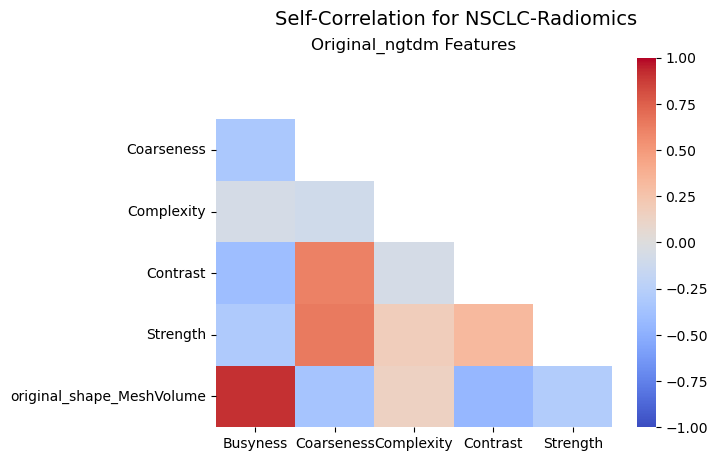

In [170]:
dataset = 'NSCLC-Radiomics'
dataset_config, dataset_name, full_dataset_name = load_dataset_config(dataset)
subset_keyword = 'original_ngtdm'

self_corr_pd = self_correlate(dataset,
               correlation_method = "pearson",
               extract_method = "pyradiomics",
               extract_settings = "pyradiomics_h4h_all_images_features",
               readii_permutation = "original",
               readii_region = "full",
               plot_include_volume = True,
               plot = True,
               plot_subset_keyword=subset_keyword,
               plot_overwrite=False)